# Importing libraries and reading files

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import nltk
import re

In [ ]:
# Read data from files
data_t = pd.read_excel('/content/drive/MyDrive/quantium/QVI_transaction_data.xlsx')
data_p = pd.read_csv('/content/drive/MyDrive/quantium/QVI_purchase_behaviour.csv')

# Transactions data

In [ ]:
data_t.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [ ]:
# Find the dimensions of the datasets
data_t.shape

(264836, 8)

In [ ]:
# FInd datatypes in datasets
data_t.dtypes

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

In [ ]:
# change the date datatype to display the correct format of dates
def convertdate(x):
 serial = x
 seconds = (serial - 25569) * 86400.0
 return datetime.datetime.utcfromtimestamp(seconds)

data_t['DATE'] = data_t['DATE'].apply(lambda x:convertdate(x))

data_t.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [ ]:
# Check for null values
data_t.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [ ]:
# Check for number of unique values
data_t.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

In [ ]:
data_t['TXN_ID'].nunique()

263127

TXN_ID is not unique to each row. This is because there can be sales of chips with different brands in a single transaction.

In [ ]:
data_t['PROD_QTY'].unique()

array([  2,   3,   5,   1,   4, 200])

There seems to be an anomaly in PROD_QTY as there seems to be a sale of 200 packets of chips in single transaction(s). Lets look at those transactions

In [ ]:
data_t[data_t['PROD_QTY'] == 200].shape

(2, 8)

In [ ]:
data_t[data_t['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Both the transactions were done by the same customer, on different days.

Lets look at the other transactions by te same customer

In [ ]:
data_t[data_t['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It seems that the customer is not a retail buyer as he/she has made a bulk/ wholesale purchase. So lets remove the customer from the dataframe

In [ ]:
data_t.drop(data_t.loc[data_t['LYLTY_CARD_NBR']==226000].index, inplace=True)
data_t.shape

(264834, 8)

Lets count the number of unique dates and the maximum and minimum dates to check how many days worth of data are provided

In [ ]:
data_t['DATE'].nunique(), data_t['DATE'].min(), data_t['DATE'].max()

(364, Timestamp('2018-07-01 00:00:00'), Timestamp('2019-06-30 00:00:00'))

It shows that the data has only 364 days' worth of data starting from 1 July 2018 to 30 June 2019, with one missing date.

Lets create a dataframe with dates starting from 1 July 2018 to 30 June 2019, and join it with the data. This will give us an idea of which date's data is missing

In [ ]:
df = pd.DataFrame({'DATE':pd.date_range('2018-07-01', '2019-06-30')}) 
df.head()

,DATE
0,2018-07-01
1,2018-07-02
2,2018-07-03
3,2018-07-04
4,2018-07-05


In [ ]:
# Merge df with data_t on DATE and check for the row with missing data
data_temp = pd.merge(data_t, df, on='DATE', how='outer')
null_data = data_temp[data_temp.isnull().any(axis=1)]
null_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
264834,2018-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the date coincides with the christmas day, its safe to assume that it was not a working day for the business and hence, no transactions were recorded.

In [ ]:
# Create a new dataframe which contains the total sale for each date

a = pd.pivot_table(data_t, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.head()

,TOT_SALES
DATE,
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


In [ ]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['TOT_SALES'] = 0
len(b)

365

In [ ]:
c = a + b
c.fillna(0, inplace = True)
c.head()

,TOT_SALES
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


In [ ]:
c.index.name = 'Date'
c.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
c.head()

,Total Sales
Date,
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


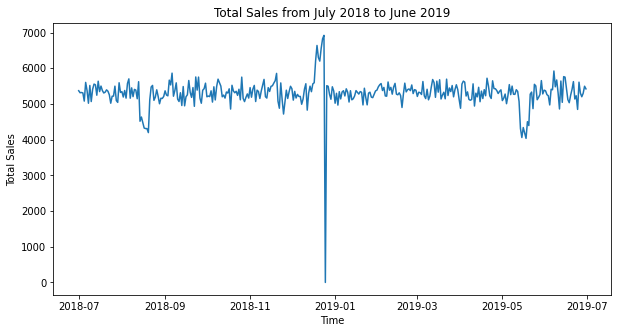

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
timeline = c.index
graph = c['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

We can see that sales spike up during the December month and zero sale on Christmas Day.

In [ ]:
# Confirm the date where sales count equals to zero
c[c['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [ ]:
# Let's look at the December month only
c_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]
c_december.head()

,Total Sales
Date,
2018-12-01,5427.6
2018-12-02,5108.2
2018-12-03,5353.3
2018-12-04,5167.3
2018-12-05,5268.0


Text(0.5, 1.0, 'Total Sales in December')

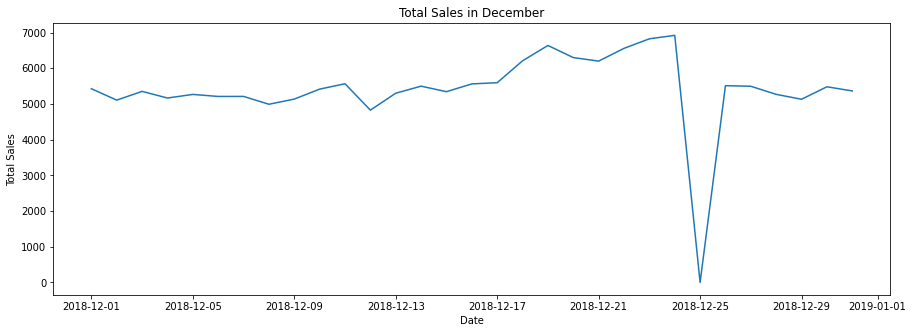

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(c_december)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December')

Lets now create new columns Product_brand and pack_size from PROD_NAME

In [ ]:
# Create pack size column
search = []    
for values in data_t['PROD_NAME']:
    search.append(re.search(r'\d+', values).group())

data_t['Pack-size'] = search
data_t['Pack-size'] = pd.to_numeric(data_t['Pack-size'])

data_t.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [ ]:
# Check for the minimum and maximum packet sizes
print('Minimum pack size:' + str(data_t['Pack-size'].min())), print('Maximum pack size:' + str(data_t['Pack-size'].max()))

Minimum pack size:70
Maximum pack size:380


(None, None)

Text(0.5, 1.0, 'Transactions based on Pack-size')

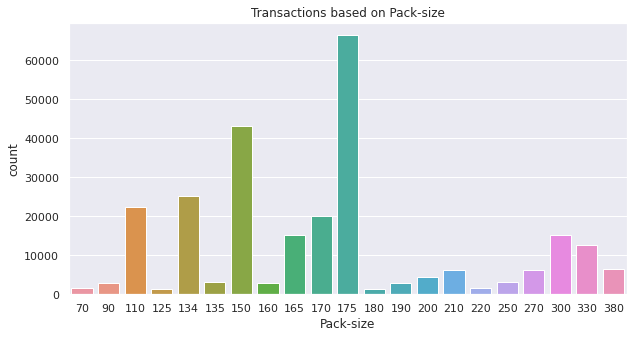

In [ ]:
# Plot transactions based on Pack-size
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.countplot(x="Pack-size", data=data_t)
plt.title('Transactions based on Pack-size')

We can observe the most number of transactions happened with packet sizes 175g and 150g.

In [ ]:
# Create new column Brand
data_t['Brand'] = data_t['PROD_NAME'].str.partition(' ')[0]
data_t.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size,Brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


In [ ]:
# Check unique values for Brand
data_t['Brand'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

There seems to be inconsistencies in the brand names. Lets change them

In [ ]:
di = {'Dorito':'Doritos', 'Infzns':'Infuzions', 'Smith':'Smiths', 'GrnWves':'Grain', 'WW':'Woolworths', 'RRD':'Red', 'Snbts':'Sunbites', 'NCC':'Natural'}
data_t.replace({"Brand": di}, inplace=True)
data_t['Brand'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red', 'Pringles', 'Tyrrells', 'Cobs', 'French',
       'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

# Purchase Behaviour

In [ ]:
# Display sample data from purchase behaviour data
data_p.head(3)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget


In [ ]:
data_p.shape

(72637, 3)

In [ ]:
data_p.dtypes

LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

In [ ]:
# Check for null values
data_p.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [ ]:
# Number of unique values in dataset
data_p.nunique()

LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

Since the number of rows in customerData is equal to number of unique loyalty card number, we conclude that loyalty card numbers are unique to each row.

In [ ]:
data_p['LIFESTAGE'].unique(), data_p['PREMIUM_CUSTOMER'].unique()

(array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
        'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
        'RETIREES'], dtype=object),
 array(['Premium', 'Mainstream', 'Budget'], dtype=object))

Text(0.5, 1.0, 'Number of customers in each LIFESTAGEs')

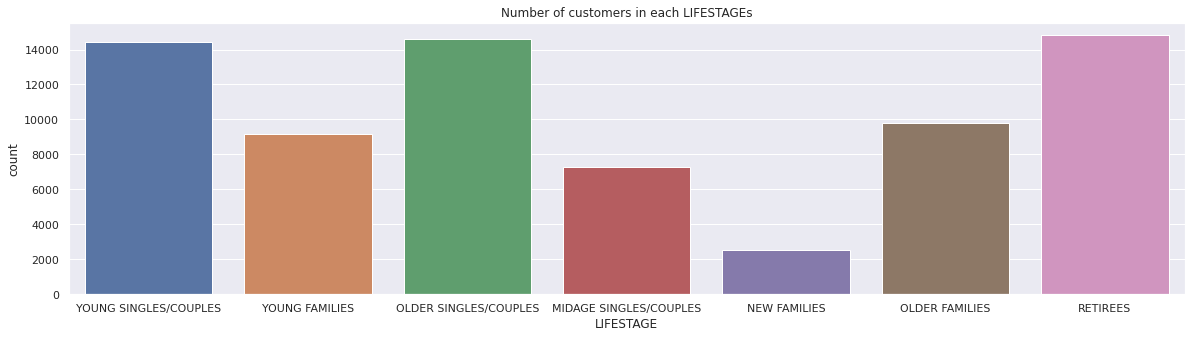

In [ ]:
# Countplot on Lifestage and Premium_Customer
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,5))
sns.countplot(x="LIFESTAGE", data=data_p, dodge=False)
plt.title('Number of customers in each LIFESTAGEs')

Text(0.5, 1.0, 'Number of customers in each PREMIUM types')

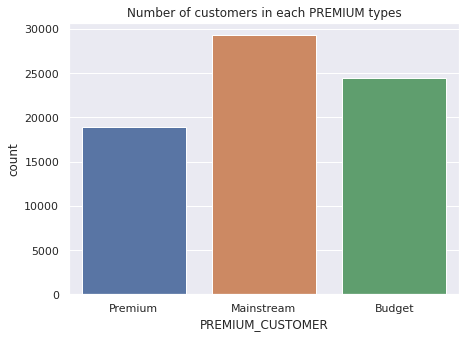

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(7,5))
sns.countplot(x="PREMIUM_CUSTOMER", data=data_p, dodge=False)
plt.title('Number of customers in each PREMIUM types')

<Figure size 1800x360 with 0 Axes>

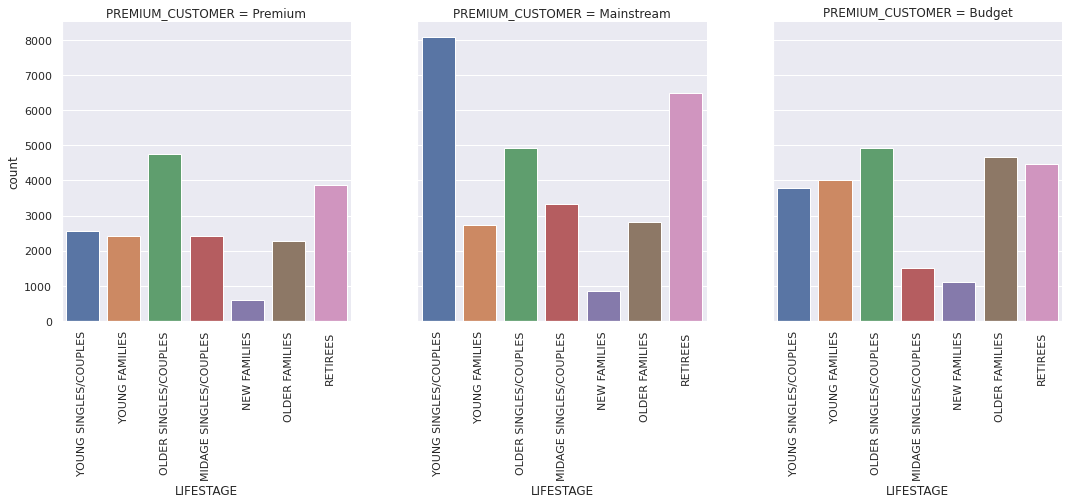

In [ ]:
plt.figure(figsize=(25,5))
a = sns.catplot(x="LIFESTAGE", col="PREMIUM_CUSTOMER",
                data=data_p, kind="count")
a.set_xticklabels(rotation=90)

# Merge datasets

In [ ]:
# Merge the 2 dataframes
data_new = data_t.merge(data_p, on='LYLTY_CARD_NBR', how='left')
data_new.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
Pack-size           0
Brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [ ]:
data_new.shape

(264834, 12)

In [ ]:
data_new.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size,Brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


# Export to excel


In [ ]:
writer = pd.ExcelWriter('quantium_clean.xlsx')

# Write each dataframe to a different worksheet.
data_new.to_excel(writer, sheet_name='Merged')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Data Analysis

Lets check who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is.


In [ ]:
# Total sales by PREMIUM_CUSTOMER and LIFESTAGE
sales = pd.DataFrame(data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            168363.25
Mainstream       YOUNG SINGLES/COUPLES     157621.60
                 RETIREES                  155677.05
Budget           YOUNG FAMILIES            139345.85
                 OLDER SINGLES/COUPLES     136769.80
Mainstream       OLDER SINGLES/COUPLES     133393.80
Premium          OLDER SINGLES/COUPLES     132263.15
Budget           RETIREES                  113147.80
Mainstream       OLDER FAMILIES            103445.55
Premium          RETIREES                   97646.05
Mainstream       YOUNG FAMILIES             92788.75
                 MIDAGE SINGLES/COUPLES     90803.85
Premium          YOUNG FAMILIES             84025.50
                 OLDER FAMILIES             80658.40
Budget           YOUNG SINGLES/COUPLES      61141.60
Premium          MIDAGE SINGLES/COUPLES     58432.65
                 YOUNG SINGLES/COUPLES      41642.10
Budget           MIDAGE SINGLES/COUPLES     35514.80
                 NEW FAMILIES               21928.45
Mainstream       NEW FAMILIES               17013.90
Premium          NEW FAMILIES               11491.10

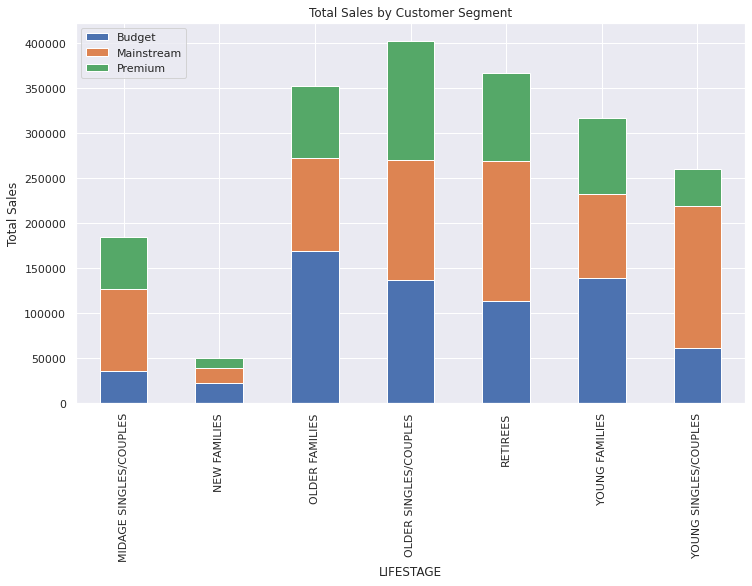

In [ ]:
# Visualise
salesPlot = pd.DataFrame(data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Top sales come from budget older families, mainstream young singles/couples and mainstream retirees.

In [ ]:
# Number of customers by PREMIUM_CUSTOMER and LIFESTAGE
customers = pd.DataFrame(data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 8088
                 RETIREES                              6479
                 OLDER SINGLES/COUPLES                 4930
Budget           OLDER SINGLES/COUPLES                 4929
Premium          OLDER SINGLES/COUPLES                 4750
Budget           OLDER FAMILIES                        4675
                 RETIREES                              4454
                 YOUNG FAMILIES                        4017
Premium          RETIREES                              3872
Budget           YOUNG SINGLES/COUPLES                 3779

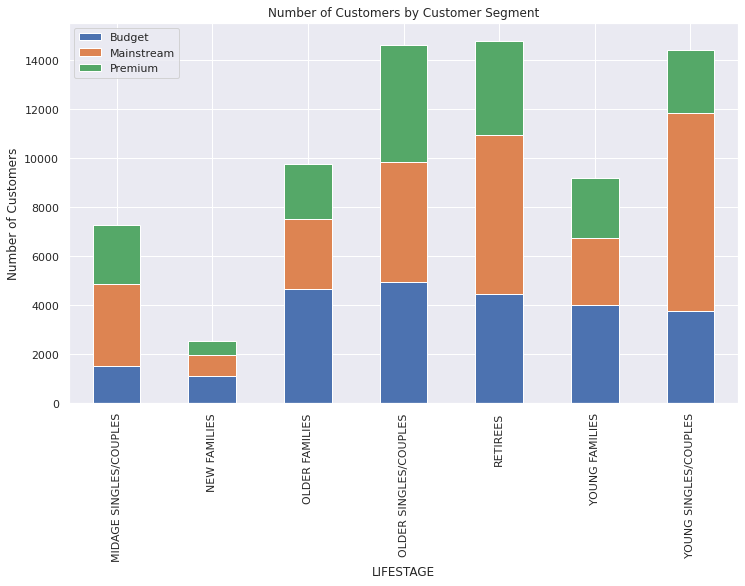

In [ ]:
customersPlot = pd.DataFrame(data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

There are more mainstream young singles/couples and retirees. This contributes to to more chips sales in these segments however this is not the major driver for the budget older families segment.

In [ ]:
# Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE
df_ppu = data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
df_ppu = pd.DataFrame(df_ppu, columns = {'Average Unit per Customer'})
df_ppu.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.804309
Budget,OLDER FAMILIES,9.639572
Premium,OLDER FAMILIES,9.578091
Budget,YOUNG FAMILIES,9.238486
Premium,YOUNG FAMILIES,9.209207


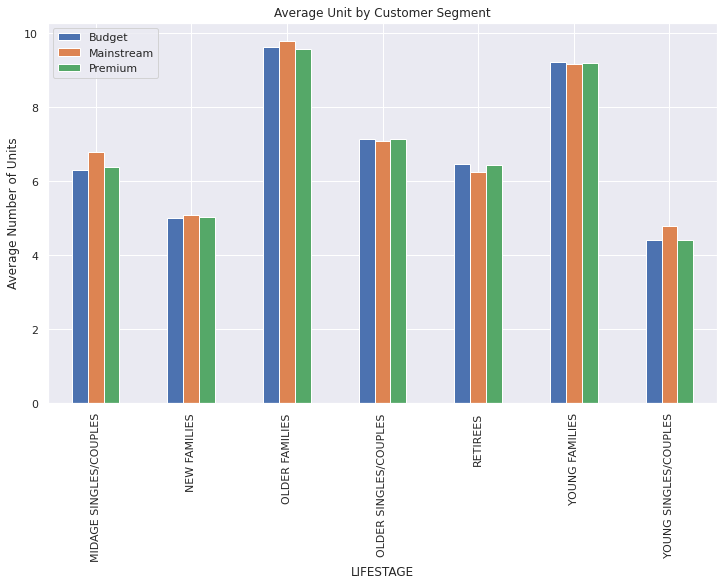

In [ ]:
df_ppu_plot = pd.DataFrame(data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
df_ppu_plot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

We can clearly aee that older families and younger families generally buy more chips per customer

In [ ]:
# Average price per unit by PREMIUM_CUSTOMER and LIFESTAGE
avg_price = data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / data_new.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.080079
                 MIDAGE SINGLES/COUPLES        4.000346
                 NEW FAMILIES                  3.939315
Budget           NEW FAMILIES                  3.936178
                 RETIREES                      3.933660

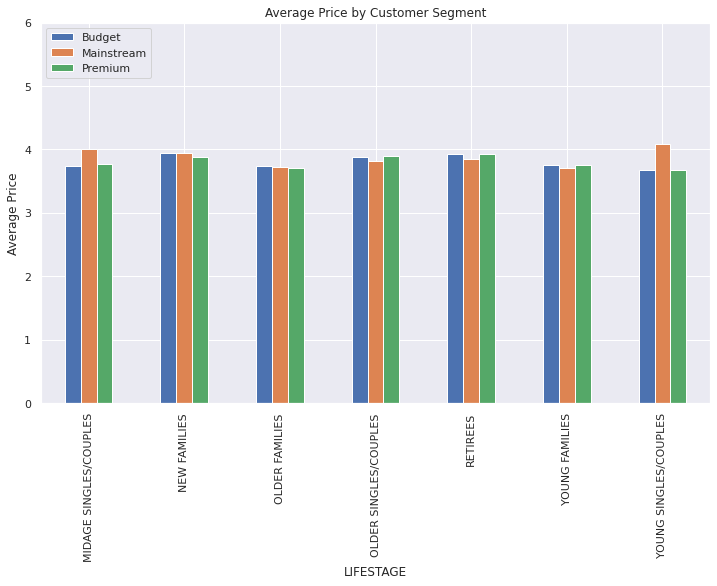

In [ ]:
avg_price_plot = pd.DataFrame(data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / data_new.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avg_price_plot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

We see that mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they do buy chips, it may be mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

---

---

Lets perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference




In [ ]:
# Create a new dataframe pricePerUnit
ppu = data_new

# Create a new column under pricePerUnit called PRICE
ppu['PRICE'] = ppu['TOT_SALES'] / ppu['PROD_QTY']

ppu.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size,Brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,4.60


In [ ]:
# Group the data into mainstream and others
mainstream = ppu.loc[(ppu['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (ppu['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (ppu['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
others = ppu.loc[(ppu['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (ppu['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (ppu['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']

Text(0.5, 0, 'Price per Unit')

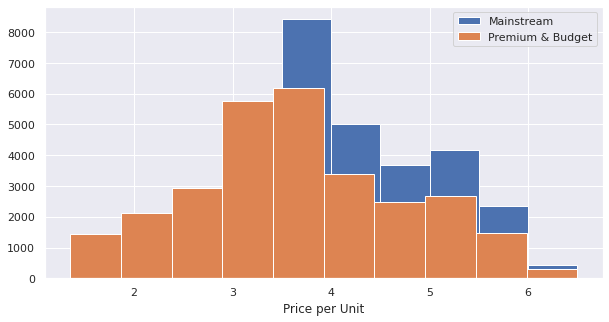

In [ ]:
# Visualise
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(others, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [ ]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-mainstream average price per unit: ${:.2f}".format(np.mean(others)))
if np.mean(mainstream) > np.mean(others):
    print("Mainstream customers have higher average price per unit. ")
else:
    print("Non-mainstream customers have a higher average price per unit. ")

Mainstream average price per unit: $4.05
Non-mainstream average price per unit: $3.69
Mainstream customers have higher average price per unit. 


We can observe that mainstream customers have higher average price per unit than non-mainstream customers.

We have found quite a few interesting insights that we can dive deeper into. For example, we might want to target customers segments that contribute the most to sales to retain them to further increase sales. Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips.

In [ ]:
target = data_new.loc[(data_new['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data_new['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = data_new.loc[(data_new['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (data_new['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size,Brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
237700,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag&Sauce 150g,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
237701,2018-08-17,1,1163,188,46,Kettle Original 175g,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
237702,2018-08-14,1,1291,333,27,WW Supreme Cheese Corn Chips 200g,1,1.9,200,Woolworths,YOUNG SINGLES/COUPLES,Mainstream,1.9
237703,2019-05-15,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag 380g,1,5.9,380,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.9
237704,2019-05-18,3,3118,1574,62,Pringles Mystery Flavour 134g,1,3.7,134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7


In [ ]:
nonTarget.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pack-size,Brand,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,4.60
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1,300,Old,MIDAGE SINGLES/COUPLES,Budget,5.10


**Affinity to brand**
*************************

In [ ]:
# Target Segment
targetBrand = target.loc[:, ['Brand', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('Brand')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['Brand', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('Brand')['Non-Target Brand Affinity'].sum())

In [ ]:
# Merge the two dataframes together
brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
Brand,,
Burger,0.002744,0.006094
CCs,0.010484,0.017191
Cheetos,0.007533,0.010960
Cheezels,0.016851,0.017619
Cobs,0.041856,0.035836


In [ ]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
Brand,,,
Tyrrells,0.029587,0.023968,1.234454
Twisties,0.043306,0.035355,1.224877
Kettle,0.185649,0.155243,1.195863
Tostitos,0.042581,0.035744,1.191269
Old,0.041598,0.034931,1.190850
Pringles,0.111980,0.094240,1.188241
Cobs,0.041856,0.035836,1.167987
Doritos,0.122877,0.105278,1.167174
Infuzions,0.060649,0.053509,1.133443


Looks like, mainstream young singles/couples are more likely to purchase Tyrrell followed by Twisties chips compared to other brands.

---

---

---







Pack Size


---





In [ ]:
# Target segment 
targetSize = target.loc[:, ['Pack-size', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('Pack-size')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['Pack-size', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('Pack-size')['Non-Target Pack Affinity'].sum())

# Merge the two dataframes together
pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
Pack-size,,
70,0.002847,0.005857
90,0.005954,0.011756
110,0.099658,0.083489
125,0.002821,0.005570
134,0.111980,0.094240


In [ ]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
Pack-size,,,
270,0.029846,0.023366,1.277295
380,0.030156,0.023964,1.258400
330,0.057465,0.047511,1.209522
110,0.099658,0.083489,1.193675
134,0.111980,0.094240,1.188241
210,0.027309,0.023200,1.177104
135,0.013849,0.012053,1.149001
250,0.013460,0.011989,1.122716
170,0.075740,0.074888,1.011386


In [ ]:
# Find brands that offers 270g pack size
data_new.loc[data_new['Pack-size'] == 270, 'Brand'].unique()

array(['Twisties'], dtype=object)

Twisties is the only brand that offers 270g pack size.

# Conclusion
*************************************************************************************************************************************************************************************

After all our preliminary analysis done above, we might be able to conclude(as for now), that 

*   more focus should be given to the Mainstream customers, 
specifically the YOUNG SINGLES and COUPLES. This can be also followed by the OLD customers, specifically the RETIREES.
*   Sales are highest for Budget, OLDER FAMILIES; Mainstream, YOUNG SINGLES/COUPLES and Mainstream, RETIREES
*   Mainstream, YOUNG SINGLES/COUPLES are more likely to pay more per packet of chips than their premium and budget counterparts
*   They are also more likely to purchase 'Tyrrells'/'Twisties' and '270g' pack sizes than the rest of the population



